In [136]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch 
from torch import nn
import os
import torchvision
import torch.nn.functional as F
from torch import tensor
from torch.utils.data import DataLoader
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
from tqdm import tqdm
from matplotlib import pyplot as plt
import json
import random
%matplotlib inline
random.seed(69)
torch.backends.cudnn.deterministic = True
np.random.seed(69)
torch.manual_seed(69)
torch.cuda.manual_seed_all(69)

In [137]:
class CustomCNN(nn.Module):
    
    def __init__(self, num_classes):
        
        super(CustomCNN, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batch_norm1 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batch_norm2 = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batch_norm3 = nn.BatchNorm2d(128)

        self.conv8 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1)  # default stride is 2
        self.batch_norm4 = nn.BatchNorm2d(256)

        self.conv11 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=1)  # default stride is 2
        self.batch_norm5 = nn.BatchNorm2d(512)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        
        x1 = F.leaky_relu(self.conv1(x))
        x1 = self.pool1(x1)
        x1 = self.batch_norm1(x1)
        
        x2 = F.leaky_relu(self.conv3(x1))
        x2 = self.pool2(x2)
        x2 = self.batch_norm2(x2)

        x3 = F.leaky_relu(self.conv5(x2))
        x3 = self.pool3(x3)
        x3 = self.batch_norm3(x3)

        x4 = F.leaky_relu(self.conv8(x3))
        x4 = self.pool4(x4)
        x4 = self.batch_norm4(x4)

        x5 = F.leaky_relu(self.conv11(x4))
        x5 = self.pool5(x5)
        x5 = self.batch_norm5(x5)
        
        y = self.flatten(x5)
        y = F.leaky_relu(self.fc1(y))
        return x1, x2, x3, x4, x5, y

In [138]:
class CustomCNN_sieve(nn.Module):

    def __init__(self, shape1, shape2, shape3, shape4, shape5, num_classes):

        super().__init__()
        self.num_classes = num_classes
        self.core_network = CustomCNN(self.num_classes)
        
        self.shape1 = shape1
        self.shape2 = shape2
        self.shape3 = shape3
        self.shape4 = shape4
        self.shape5 = shape5
        
        self.sieve1 = nn.Linear(self.shape1[0] * self.shape1[1] * self.shape1[2], self.num_classes)
        self.sieve2 = nn.Linear(self.shape2[0] * self.shape2[1] * self.shape2[2], self.num_classes)
        self.sieve3 = nn.Linear(self.shape3[0] * self.shape3[1] * self.shape3[2], self.num_classes)
        self.sieve4 = nn.Linear(self.shape4[0] * self.shape4[1] * self.shape4[2], self.num_classes)
        self.sieve5 = nn.Linear(self.shape5[0] * self.shape5[1] * self.shape5[2], self.num_classes)
        self.flatten = nn.Flatten(start_dim = 1, end_dim = 3)

    def forward(self, x):

        s1, s2, s3, s4, s5, main_output = self.core_network(x)
        return self.sieve1(self.flatten(s1)), self.sieve2(self.flatten(s2)), self.sieve3(self.flatten(s3)), self.sieve4(self.flatten(s4)), self.sieve5(self.flatten(s5)), main_output
        

In [139]:
class small_model(nn.Module):
    def __init__(self, input_dims, num_classes):

        super().__init__()
        self.num_classes = num_classes 
        self.input_dims = input_dims 
        self.layer1 = nn.Linear(input_dims[0] * input_dims[1] * input_dims[2], 500)
        self.layer2 = nn.Linear(500, 100)
        self.layer3 = nn.Linear(100, self.num_classes) 

    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(torch.flatten(x, start_dim=1, end_dim=3))))
        return x 

In [140]:
def training(model, dataloader, optimizer_core, optimizer_sieve, scheduler_core, scheduler_sieve, num_classes, valid_dataloader, weights, multi_factor1, multi_factor2, multi_factor3, k, epochs = 10):

    iters_count = 0
    avg_losses_train = []
    avg_losses_valid = []
    for i in range(len(weights)): weights[i] *=  multi_factor3
    
    for epoch in tqdm(range(epochs)):

        epoch_loss_main = 0 
        epoch_loss_sieve = 0 
        iters = 0 
        
        for iter, (image, label) in enumerate(dataloader): 

            optimizer_core.zero_grad()
            optimizer_sieve.zero_grad()
            
            image, label = image.to(device), label.to(device)
            model.train()
            
            _, _, _, _, _, main_output = model(image)
            main_loss = multi_factor1 * F.binary_cross_entropy_with_logits(main_output, label)
            epoch_loss_main += main_loss.item()
            iters += 1
            iters_count+=1
            
            main_loss.backward()
            optimizer_core.step()
            model.core_network.eval()

            s1, s2, s3, s4, s5, _ = model(image)
            loss1 = F.binary_cross_entropy_with_logits(s1, label)
            loss2 = F.binary_cross_entropy_with_logits(s2, label)
            loss3 = F.binary_cross_entropy_with_logits(s3, label)
            loss4 = F.binary_cross_entropy_with_logits(s4, label)
            loss5 = F.binary_cross_entropy_with_logits(s5, label)

            loss = multi_factor2 * (loss1 + loss2 + loss3 + loss4 + loss5)
            epoch_loss_sieve += loss.item()
            loss.backward()

            optimizer_sieve.step()
            # optimizer_weights.step()
            if(iters_count%k == 0): forgetting_subroutine(model, weights, multi_factor3, image, optimizer_core, scheduler_core, num_classes)
            image, label = image.to('cpu'), label.to('cpu')

            if(scheduler_core): scheduler_core.step()
            if(scheduler_sieve): scheduler_sieve.step()
            
        avg_losses_train.append(epoch_loss_main/iters)
        # for i in range(len(weights)): weights[i] *= 1

        model.eval()
        iters = 0 
        valid_loss = 0 
        
        for image,label in valid_dataloader: 
    
            image, label = image.to(device), label.to(device)
            _, _, _, _, _, main_output = model(image)
            main_loss = F.binary_cross_entropy_with_logits(main_output, label)
            valid_loss += main_loss.item()
            iters+=1 

        avg_losses_valid.append(valid_loss/iters)

    print(f'Final validation loss achieved: {np.array(avg_losses_valid[-1])}')
    plt.figure(figsize = (25,25))
    fig, axes = plt.subplots(2,1)
    
    axes[0].plot(range(epochs), avg_losses_train, color = 'blue')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Average train loss')

    axes[1].plot(range(epochs), avg_losses_valid, color = 'blue')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Average valid loss')

    plt.show()

In [141]:
def forgetting_subroutine(model, weights, multi_factor3, image, optimizer_core, scheduler_core, num_classes):

    # print(weights)
    total_loss1 = 0
    total_loss2 = 0
    total_loss3 = 0
    total_loss4 = 0
    total_loss5 = 0

    label = torch.ones((image.shape[0], num_classes), dtype = torch.float).to(device)
    label = label/num_classes 
    
    model.eval()
    s1, s2, s3, s4, s5, _ = model(image)
    optimizer_core.zero_grad() 
    
    model.sieve1.train()
    model.core_network.conv1.train()
    model.core_network.pool1.train()
    model.core_network.batch_norm1.train()
    loss1 = weights[0]*F.binary_cross_entropy_with_logits(s1, label)
    total_loss1 += loss1.item()
    loss1.backward(retain_graph=True)
    model.eval()

    model.sieve2.train()
    model.core_network.conv3.train()
    model.core_network.pool2.train()
    model.core_network.batch_norm2.train()
    loss2 = weights[1]*F.binary_cross_entropy_with_logits(s2, label)
    total_loss2 += loss2.item()
    loss2.backward(retain_graph=True)
    model.eval()

    model.sieve3.train()
    model.core_network.conv5.train()
    model.core_network.pool3.train()
    model.core_network.batch_norm3.train()
    loss3 = weights[2]*F.binary_cross_entropy_with_logits(s3, label)
    total_loss3 += loss3.item()
    loss3.backward(retain_graph=True)
    model.eval()

    model.sieve4.train()
    model.core_network.conv8.train()
    model.core_network.pool4.train()
    model.core_network.batch_norm4.train()
    loss4 = weights[3]*F.binary_cross_entropy_with_logits(s4, label)
    total_loss4 += loss4.item()
    loss4.backward(retain_graph=True)
    model.eval()

    model.sieve5.train()
    model.core_network.conv11.train()
    model.core_network.pool5.train()
    model.core_network.batch_norm5.train()
    loss5 = weights[4]*F.binary_cross_entropy_with_logits(s5, label)
    total_loss5 += loss5.item()
    loss5.backward(retain_graph=True)
    model.eval()

    optimizer_core.step()
    if(scheduler_core): scheduler_core.step()

    image = image.to('cpu')
    label = label.to('cpu')

## Code to load cifarmnist dataset

In [ ]:
train_images_path = '/kaggle/input/cifar-10-mnist/Cifar10_Mnist_Lite/'
labels_path = train_images_path + 'labels.json'
with open(labels_path, "r") as json_file:
    data = json.load(json_file)

In [ ]:
data['Datas/Cifar10_Mnist_Lite/combined_image_999.png']

In [ ]:
start_path = 'Datas/Cifar10_Mnist_Lite/'
cifar_dataset = []
for image_file in os.listdir(train_images_path):
    if image_file.endswith('.json'): continue
    img = tensor(torchvision.io.read_image(train_images_path + image_file), dtype = torch.float)
    label_cifar = data[start_path + image_file]['cifar10_label']
    label_mnist = data[start_path + image_file]['mnist_label']
    cifar_dataset.append((img,label_cifar,label_mnist))

## Code to load colormnist dataset

In [142]:
# green 0 and red 1 in training 
# red 0 and green 1 in testing

In [143]:
train_0_path = '/kaggle/input/colored-mnist-dataset/colorized-MNIST-master/training/0/'
train_1_path = '/kaggle/input/colored-mnist-dataset/colorized-MNIST-master/training/1/'

In [144]:
train_dataset = []
for image_file in os.listdir(train_0_path):
    img = tensor(torchvision.io.read_image(train_0_path + image_file), dtype = torch.float)
    image_corner = img[:, :2, :2]
    if(torch.mean(image_corner, dim = (1,2))[1] > 0):
        train_dataset.append((img, torch.tensor([1,0], dtype = torch.float)))
        
for image_file in os.listdir(train_1_path):
    img = tensor(torchvision.io.read_image(train_1_path + image_file), dtype = torch.float)
    image_corner = img[:, :2, :2]
    if(torch.mean(image_corner, dim = (1,2))[0] > 0):
        train_dataset.append((img, torch.tensor([0,1], dtype = torch.float)))
        
random.shuffle(train_dataset)

/tmp/ipykernel_30/4212284886.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = tensor(torchvision.io.read_image(train_0_path + image_file), dtype = torch.float)
/tmp/ipykernel_30/4212284886.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = tensor(torchvision.io.read_image(train_1_path + image_file), dtype = torch.float)


In [145]:
test_0_path = '/kaggle/input/colored-mnist-dataset/colorized-MNIST-master/testing/0/'
test_1_path = '/kaggle/input/colored-mnist-dataset/colorized-MNIST-master/testing/1/'

In [146]:
test_dataset = []
for image_file in os.listdir(test_0_path):
    img = tensor(torchvision.io.read_image(test_0_path + image_file), dtype = torch.float)
    image_corner = img[:, :2, :2]
    if(torch.mean(image_corner, dim = (1,2))[0] > 0):
        test_dataset.append((img, torch.tensor([1,0], dtype = torch.float)))

for image_file in os.listdir(test_1_path):
    img = tensor(torchvision.io.read_image(test_1_path + image_file), dtype = torch.float)
    image_corner = img[:, :2, :2]
    if(torch.mean(image_corner, dim = (1,2))[1] > 0):
        test_dataset.append((img, torch.tensor([0,1], dtype = torch.float)))

random.shuffle(test_dataset)

/tmp/ipykernel_30/912960757.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = tensor(torchvision.io.read_image(test_0_path + image_file), dtype = torch.float)
/tmp/ipykernel_30/912960757.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = tensor(torchvision.io.read_image(test_1_path + image_file), dtype = torch.float)


In [147]:
# valid_dataset = test_dataset[int((len(test_dataset)) * 0.9):]

In [148]:
valid_dataset = train_dataset[int((len(train_dataset)) * 0.9):]
train_dataset = train_dataset[:int((len(train_dataset)) * 0.9)]

In [149]:
sample_image = train_dataset[0][0]

In [150]:
model = CustomCNN(2)

In [151]:
model.eval()
s1, s2, s3, s4, s5, main_out = model(sample_image.unsqueeze(0))

In [152]:
shape1 = s1.shape[1:]
shape2 = s2.shape[1:] 
shape3 = s3.shape[1:] 
shape4 = s4.shape[1:] 
shape5 = s5.shape[1:]

In [153]:
def get_accuracy(test_dataset, model):
    model.eval()
    correct = 0
    for i in range(len(test_dataset)):
        image = test_dataset[i][0].to(device).unsqueeze(0)
        label = test_dataset[i][1].to(device)
        
        _, _, _ ,_,_, main_pred = model(image)
        correct += torch.argmax(main_pred) == torch.argmax(test_dataset[i][1])
        
        image = image.to('cpu')
        label = label.to('cpu')
    return correct.item()/len(test_dataset) * 100 

In [154]:
batch_sizes = [4, 16, 32]
learning_rate = [1e-3, 5e-3, 7e-3]
ks = [10, 20, 30, 40, 50, 60, 70, 80, 90]
mfs1 = range(1,8)
mfs2 = range(1,8)
mfs3 = range(1,8)
ds = [1,2,3,4]

In [155]:
# Small model training
sm = small_model(sample_image.shape, 2).to(device)
batch_size = 32
dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
opt_sm = torch.optim.Adam(sm.parameters(), lr = 1e-3)
epochs = 20 

def get_accuracy_sm(test_dataset, model):
    model.eval()
    correct = 0
    for i in range(len(test_dataset)):
        image = test_dataset[i][0].to(device).unsqueeze(0)
        label = test_dataset[i][1].to(device)
        
        main_pred = model(image)
        correct += torch.argmax(main_pred) == torch.argmax(test_dataset[i][1])
        
        image = image.to('cpu')
        label = label.to('cpu')
    return correct.item()/len(test_dataset) * 100 

for epoch in range(epochs): 
    total_loss = 0
    for image, label in dataloader: 
        image, label = image.to(device), label.to(device)
        preds = sm(image)
        loss = F.binary_cross_entropy_with_logits(preds, label) 
        total_loss += loss.item()
        loss.backward() 
        opt_sm.step()

    print(f"The epoch is {epoch}, the average loss is {total_loss/len(dataloader)} the validation set accuracy is {get_accuracy_sm(valid_dataset, sm)}")

The epoch is 0, the average loss is 12.105054318904877 the validation set accuracy is 100.0
The epoch is 1, the average loss is 0.0 the validation set accuracy is 100.0
The epoch is 2, the average loss is 0.0 the validation set accuracy is 100.0
The epoch is 3, the average loss is 0.0 the validation set accuracy is 100.0
The epoch is 4, the average loss is 0.0 the validation set accuracy is 100.0
The epoch is 5, the average loss is 0.0 the validation set accuracy is 100.0
The epoch is 6, the average loss is 0.0 the validation set accuracy is 100.0
The epoch is 7, the average loss is 0.0 the validation set accuracy is 100.0
The epoch is 8, the average loss is 0.0 the validation set accuracy is 100.0
The epoch is 9, the average loss is 0.0 the validation set accuracy is 100.0
The epoch is 10, the average loss is 0.0 the validation set accuracy is 100.0
The epoch is 11, the average loss is 0.0 the validation set accuracy is 100.0
The epoch is 12, the average loss is 0.0 the validation set

In [21]:
from collections import defaultdict
import torch
import torch.nn.functional as F
from tqdm import tqdm

def compute_cmi_dataloader(model1, model2, dataloader, num_classes, label_to_evaluate, logits_pos, temperature=1.0):
    # Initialize distributions
    joint_counts = defaultdict(lambda: torch.zeros((num_classes, num_classes), requires_grad=True, device='cuda'))  # Ensure tensors are on the correct device
    marginal_m1_counts = defaultdict(lambda: torch.zeros(num_classes, requires_grad=True, device='cuda'))
    marginal_m2_counts = defaultdict(lambda: torch.zeros(num_classes, requires_grad=True, device='cuda'))
    label_counts = defaultdict(int)

    # Iterate through the dataloader
    for inputs, labels in tqdm(dataloader):
        # Move data to the correct device
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        # Select only the samples with the specific label
        mask = torch.argmax(labels, dim=1) == label_to_evaluate
        if mask.sum() == 0:
            continue
        inputs, labels = inputs[mask], labels[mask]

        # Get model predictions
        all_logits = model1(inputs)  # [batch_size, num_classes]
        logits2 = model2(inputs)  # [batch_size, num_classes]
        logits1 = all_logits[logits_pos]

        # Convert logits to probabilities using Softmax
        probs1 = F.softmax(logits1 / temperature, dim=-1)  # [batch_size, num_classes]
        probs2 = F.softmax(logits2 / temperature, dim=-1)  # [batch_size, num_classes]

        # Compute differentiable approximations for joint and marginal counts
        batch_size = probs1.size(0)
        for i in range(batch_size):
            joint_counts[label_to_evaluate] = joint_counts[label_to_evaluate] + torch.outer(probs1[i], probs2[i])  # Explicit addition
            marginal_m1_counts[label_to_evaluate] = marginal_m1_counts[label_to_evaluate] + probs1[i]
            marginal_m2_counts[label_to_evaluate] = marginal_m2_counts[label_to_evaluate] + probs2[i]

        label_counts[label_to_evaluate] += batch_size

    # Normalize distributions
    label_count = label_counts[label_to_evaluate]
    joint_probs = joint_counts[label_to_evaluate] / label_count
    marginal_m1_probs = marginal_m1_counts[label_to_evaluate] / label_count
    marginal_m2_probs = marginal_m2_counts[label_to_evaluate] / label_count

    # Calculate CMI
    cmi = 0.0
    for m1 in range(num_classes):
        for m2 in range(num_classes):
            p_joint = joint_probs[m1, m2]
            p_m1 = marginal_m1_probs[m1]
            p_m2 = marginal_m2_probs[m2]
            if p_joint > 0 and p_m1 > 0 and p_m2 > 0:
                cmi += p_joint * torch.log(p_joint / (p_m1 * p_m2))

    return cmi  # The output is differentiable!

def compute_cmi_batch(model1, model2, inputs, labels, num_classes, label_to_evaluate, logits_pos, temperature=1.0):
    # Initialize distributions
    joint_counts = defaultdict(lambda: torch.zeros((num_classes, num_classes), requires_grad=True, device='cuda'))  # Ensure tensors are on the correct device
    marginal_m1_counts = defaultdict(lambda: torch.zeros(num_classes, requires_grad=True, device='cuda'))
    marginal_m2_counts = defaultdict(lambda: torch.zeros(num_classes, requires_grad=True, device='cuda'))
    label_counts = defaultdict(int)
    # Move data to the correct device
    inputs, labels = inputs.to('cuda'), labels.to('cuda')
    mask = torch.argmax(labels, dim=1) == label_to_evaluate
    if mask.sum() == 0:
        return 0
    inputs, labels = inputs[mask], labels[mask]

    # Get model predictions
    all_logits = model1(inputs)  # [batch_size, num_classes]
    logits2 = model2(inputs)  # [batch_size, num_classes]
    logits1 = all_logits[logits_pos]

    # Convert logits to probabilities using Softmax
    probs1 = F.softmax(logits1 / temperature, dim=-1)  # [batch_size, num_classes]
    probs2 = F.softmax(logits2 / temperature, dim=-1)  # [batch_size, num_classes]

    # Compute differentiable approximations for joint and marginal counts
    batch_size = probs1.size(0)
    for i in range(batch_size):
        joint_counts[label_to_evaluate] = joint_counts[label_to_evaluate] + torch.outer(probs1[i], probs2[i])  # Explicit addition
        marginal_m1_counts[label_to_evaluate] = marginal_m1_counts[label_to_evaluate] + probs1[i]
        marginal_m2_counts[label_to_evaluate] = marginal_m2_counts[label_to_evaluate] + probs2[i]

    label_counts[label_to_evaluate] += batch_size

    # Normalize distributions
    label_count = label_counts[label_to_evaluate]
    joint_probs = joint_counts[label_to_evaluate] / label_count
    marginal_m1_probs = marginal_m1_counts[label_to_evaluate] / label_count
    marginal_m2_probs = marginal_m2_counts[label_to_evaluate] / label_count

    # Calculate CMI
    cmi = 0.0
    for m1 in range(num_classes):
        for m2 in range(num_classes):
            p_joint = joint_probs[m1, m2]
            p_m1 = marginal_m1_probs[m1]
            p_m2 = marginal_m2_probs[m2]
            if p_joint > 0 and p_m1 > 0 and p_m2 > 0:
                cmi += p_joint * torch.log(p_joint / (p_m1 * p_m2))

    return cmi  # The output is differentiable!

In [22]:
models = []

alpha1: 2, alpha2: 1, alpha3: 2


100%|██████████| 10/10 [00:01<00:00,  6.35it/s]

Final validation loss achieved: 0.31951704621315


<Figure size 2500x2500 with 0 Axes>

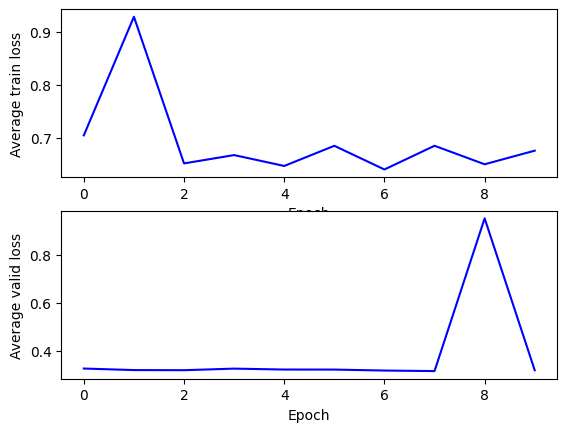

In [133]:
multi_factor1 = 2
multi_factor2 = 1
multi_factor3 = 2
print(f"alpha1: {multi_factor1}, alpha2: {multi_factor2}, alpha3: {multi_factor3}")
d = 2
k = 30
weights = np.array([1, 1/d, 1/d**2, 1/d**3, 1/d**4])
# weights = [1,0,0,0,0]
# weights = [0,0,0,0,0]
batch_size = 32
base_lr = 1e-3
max_lr = 3e-3
# k = 10
# lr = (base_lr + max_lr)/2
model_sieve = CustomCNN_sieve(shape1, shape2, shape3, shape4, shape5, 2).to(device)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = True)
dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
opt_core = torch.optim.Adam(model_sieve.parameters(), lr = base_lr)
opt_sieve = torch.optim.Adam(
    list(model_sieve.sieve1.parameters()) +
    list(model_sieve.sieve2.parameters()) +
    list(model_sieve.sieve3.parameters()) +
    list(model_sieve.sieve4.parameters()) +
    list(model_sieve.sieve5.parameters()),
    lr=base_lr)

scheduler_core = torch.optim.lr_scheduler.CyclicLR(opt_core, base_lr, max_lr)
scheduler_sieve = torch.optim.lr_scheduler.CyclicLR(opt_sieve, base_lr, max_lr)

model.train()
training(model_sieve, dataloader, opt_core, opt_sieve, scheduler_core, scheduler_sieve, 2, valid_dataloader, weights, multi_factor1, multi_factor2, multi_factor3, k, 10)
# models.append(model_sieve)

In [134]:
get_accuracy(train_dataset, model_sieve)

100.0

In [135]:
get_accuracy(test_dataset, model_sieve)

0.1402524544179523

In [209]:
def get_accuracy_ens(models, test_dataset, labels):

    correct = 0
    for model in models:
        model.eval()
    for i in range(len(test_dataset)):
        preds = {}
        for label_ in labels:
            preds[label_] = 0 
        
        image = test_dataset[i][0].to(device).unsqueeze(0)
        for model in models:
            _, _, _ ,_,_, main_pred = model(image)
            pred = torch.argmax(main_pred)
            preds[pred.item()]+=1
        
        image = image.to('cpu')
        max_key = max(preds, key=preds.get)
        correct += max_key == torch.argmax(test_dataset[i][1])
    
    return correct.item()/len(test_dataset) * 100

In [210]:
# get_accuracy_ens(models, train_dataset, (0,1))

100.0

In [211]:
# get_accuracy_ens(models, test_dataset, (0,1))

0.0

0.0

In [ ]:
# image_tensor = next(train_iter)[0]
# plt.imshow(image_tensor.permute(1,2,0))
# image_tensor = image_tensor[:, :5, :5]
# print(image_tensor)